<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus: ",data['Word'].nunique())
print("Unique tags in corpus: ",data['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus:  17


In [4]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [6]:
num_words,num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class Sentencegetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),
                                                      s['POS'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = Sentencegetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx = {w:i+1 for i,w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

In [11]:
word2idx

{'Miroslav': 1,
 'anger': 2,
 'Barahona': 3,
 'Seymour': 4,
 'Calvin': 5,
 'impunity': 6,
 'Sates': 7,
 'vicinity': 8,
 'Zheng': 9,
 'Qari': 10,
 'restoring': 11,
 'crashed': 12,
 'RAMSI': 13,
 'withstand': 14,
 'mud-brick': 15,
 'newly-released': 16,
 'enthusiastically': 17,
 'anti-graft': 18,
 'pouring': 19,
 'include': 20,
 'specify': 21,
 'renegotiate': 22,
 'prayerful': 23,
 'assistants': 24,
 'Burma-Thailand': 25,
 'pro-U.S.-immigration': 26,
 'avocados': 27,
 'Lone': 28,
 'audits': 29,
 'displaced': 30,
 'auspices': 31,
 'punk': 32,
 'harangued': 33,
 'Jansen': 34,
 'Awsat': 35,
 'Agassi': 36,
 '11725': 37,
 'dispose': 38,
 'Juventus': 39,
 'pirates': 40,
 'Sutalinov': 41,
 'Zurich-based': 42,
 'Verde': 43,
 'chocolate': 44,
 'razor': 45,
 'Swazis': 46,
 'recommend': 47,
 'Joao': 48,
 'Dynamics': 49,
 '55th': 50,
 'among': 51,
 'Regina': 52,
 'Marat': 53,
 'throne': 54,
 'dreaded': 55,
 'mend': 56,
 'DOMBROVSKIS': 57,
 'strikers': 58,
 'complicate': 59,
 'depressed': 60,
 'occup

### Task 5: Padding Input Sentences and Creating Train/Test Splits

(array([1.300e+01, 1.800e+02, 7.030e+02, 1.363e+03, 2.152e+03, 2.803e+03,
        3.496e+03, 3.965e+03, 4.559e+03, 4.849e+03, 4.706e+03, 4.447e+03,
        3.814e+03, 3.117e+03, 2.433e+03, 1.699e+03, 1.767e+03, 6.490e+02,
        4.720e+02, 2.660e+02, 1.710e+02, 1.050e+02, 7.300e+01, 5.900e+01,
        2.400e+01, 1.800e+01, 2.100e+01, 6.000e+00, 9.000e+00, 6.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.06,   5.12,   7.18,   9.24,  11.3 ,  13.36,  15.42,
         17.48,  19.54,  21.6 ,  23.66,  25.72,  27.78,  29.84,  31.9 ,
         33.96,  36.02,  38.08,  40.14,  42.2 ,  44.26,  46.32,  48.38,
         50.44,  52.5 ,  54.56,  56.62,  58.68,  60.74,  62.8 ,  64.86,
         66.92,  68.98,  71.04,  73.1 ,  75.16,  77.22,  79.28,  81.34,
         83.4 , 

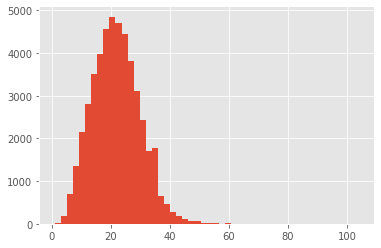

In [12]:
plt.hist([len(i) for i in sentences],bins=50)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len,sequences=x,padding='post',value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag2idx["O"])
y = [to_categorical(i,num_classes=num_tags) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation="softmax"))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

### Task 7: Train the Model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

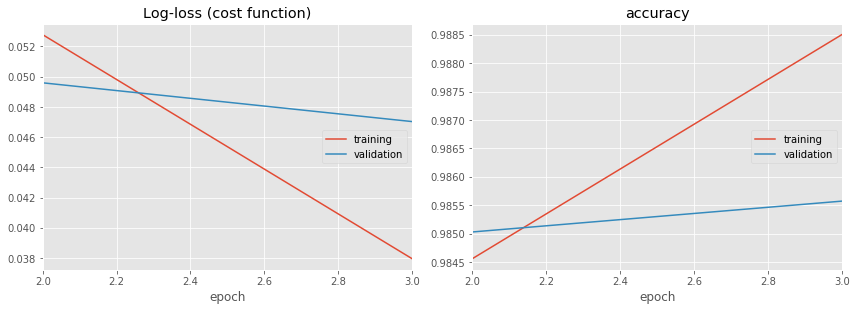

Log-loss (cost function):
training   (min:    0.038, max:    0.189, cur:    0.038)
validation (min:    0.047, max:    0.068, cur:    0.047)

accuracy:
training   (min:    0.957, max:    0.988, cur:    0.988)
validation (min:    0.981, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 190s 6ms/sample - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0470 - val_accuracy: 0.9856


In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [24]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0492 - accuracy: 0.9853


[0.04923090828991215, 0.9852585]

In [28]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=-1)

y_true = np.argmax(np.array(y_test),axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,t,p in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[t],tags[p]))

Word           True 	 Pred

------------------------------
The            B-org	O
Associated     I-org	I-org
Press          I-org	I-org
says           O	O
the            O	O
recommendation O	O
by             O	O
Colonel        O	O
James          B-per	B-per
Daniel         I-per	I-per
will           O	O
be             O	O
forwarded      O	O
to             O	O
Army           B-org	B-org
officials      O	O
for            O	O
a              O	O
final          O	O
decision       O	O
.              O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resistant      O	O
resi